In [7]:
import os
import urllib
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import torch
import torchcde
import h5py
sys.path.append(os.path.dirname(os.getcwd()))

In [8]:
targetdir = '/work/hmzhao/KMT_data/'

In [9]:
def download(targetdir, eventid):
    # https://kmtnet.kasi.re.kr/ulens/event/2019/data/KB190304/pysis/pysis.tar.gz
    file_name = 'http://kmtnet.kasi.re.kr/~ulens/event/2019/data/KB19'+str(eventid)+'/pysis/pysis.tar.gz'
    os.system("mkdir " + targetdir + 'KMT-2019-BLG-' + str(eventid))
    os.system("wget -qO "+ targetdir + "temp.tar.gz " + file_name)
    os.system("tar -xzf " + targetdir + "temp.tar.gz -C "+ targetdir + 'KMT-2019-BLG-' + str(eventid))
    os.system("rm -f " + targetdir + "temp.tar.gz")
    print('KMT-2019-BLG-' + str(eventid) + " has completed")
    return 0

def grab_param(url):
    # 打开传入的网址
    resp = urllib.request.urlopen(url)
    # 读取网页源码内容
    data = resp.read().decode('utf-8')
    labels = ["t_0","[t_E]*[t_eff]*",r"u_0","Ibase"]
    values = []
    for label in labels:
        pattern = r"<td width=130>"+label+"</td>.*</tr>"
        te_str = re.findall(pattern, data)[0]
        match_te = re.findall(r"<td>[\.\d]*</td>",te_str)
        match_te_f = re.split(r"[<>]",match_te[0])[2]
        values.append(float(match_te_f))
    return values

In [10]:
eventid_list = [
    # Planet/Binary
    '0328', '0570', '1196', '1860', '1914', 
    # Binary/Plan
    '0002', '0104', '0143', '0149', '0182',
    '0308', '0681', '0724', '1187', '1713',
    '2270', '2485', '3199', 
    # Binary
    '0021', '0200', '0209', '0236', '0270',
    '0325', '0335', '0342', '0343', '0386',
    '0412', '0535', '0561', '0609', '0649',
    '0651', '0787', '0819', '0967', '1182',
    '1195', '1281', '1291', '1334', '1363',
    '1524', '1576', '1679', '1686', '1689',
    '1700', '1722', '1850', '1984', '2063',
    '2142', '2279', '2286', '2298', '2309',
    '2324', '2496', '2596', '2599', '2655',
    '2667', '2769', '2840', '2842', '2888',
    ]
print(len(eventid_list))

68


In [ ]:
params = np.zeros((len(eventid_list), 4))
for i, eventid in tqdm(enumerate(eventid_list)):
    # download(targetdir=targetdir, eventid=eventid)
    event_url = 'http://kmtnet.kasi.re.kr/~ulens/event/2019/view.php?event=KMT-2019-BLG-' + eventid
    params[i] = grab_param(event_url)
pd.DataFrame(
    np.hstack(eventid_list.reshape(-1, 1), params), 
    columns=['eventid', 't_0', 't_E', 'u_0', 'Ibase']).to_csv(targetdir + 'params.csv')

In [11]:
params = np.loadtxt(targetdir + 'params.csv', delimiter=',', skiprows=1)[:, 1:]

In [13]:
from model.scaler import Scaler
import torchcde
import os

device = torch.device("cuda:8" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/scaler/experiment_76990.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = 1
input_dim = 3
latent_dim = ckpt_args.latents

model_s = Scaler(input_dim, latent_dim, output_dim, device).to(device)
model_dict = model_s.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model_s.load_state_dict(state_dict)
model_s.to(device)

Scaler(
  (initial): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3, out_features=1024, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=1024, out_features=32, bias=True)
    )
  )
  (gate): PReLU(num_parameters=1)
  (cnn_featurizer): Sequential(
    (0): Conv1d(32, 256, kernel_size=(15,), stride=(2,), padding=(7,))
    (1): PReLU(num_parameters=1)
    (2): Conv1d(256, 256, kernel_size=(15,), stride=(2,), padding=(7,))
    (3): PReLU(num_parameters=1)
    (4): Conv1d(256, 512, kernel_size=(15,), stride=(2,), padding=(7,))
    (5): PReLU(num_parameters=1)
    (6): CNNResBlock(
      (linear1): Conv1d(512, 128, kernel_size=(1,), stride=(1,), padding_mode=replicate)
      (nonlinear1): PReLU(num_parameters=1)
      (linear2): Conv1d(128, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=replicate)
      (layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (7): CNNResBlock(
      (linear1): Conv1d(512, 128, k

  0%|          | 0/68 [00:00<?, ?it/s]

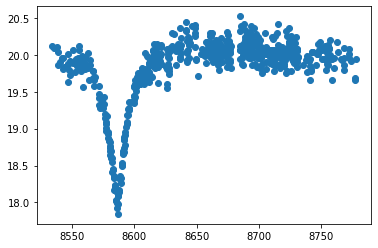

0.34321953010917916


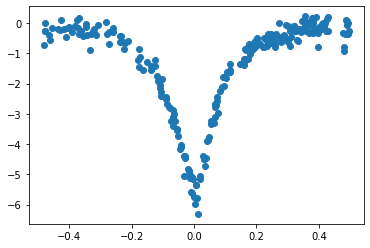

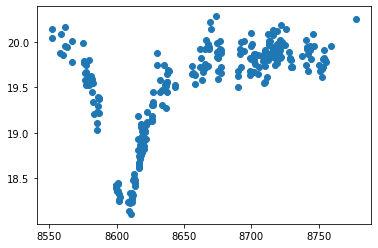

0.44015975208669617


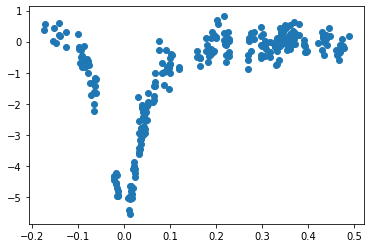

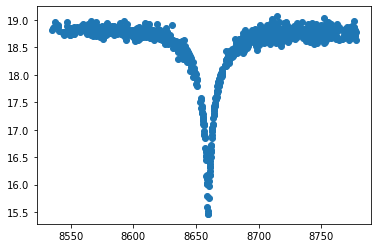

0.549258391494789


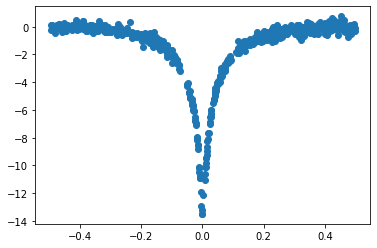

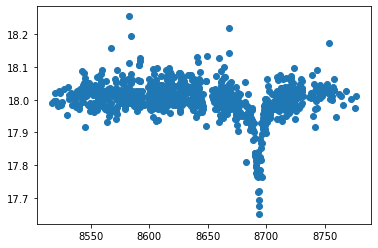

0.6632897710804029


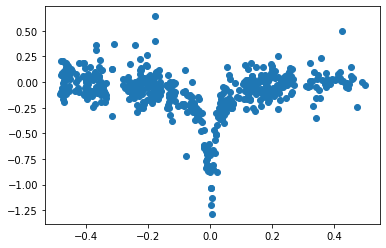

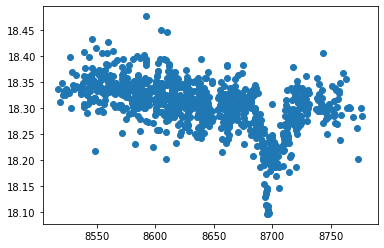

0.5726734681079393


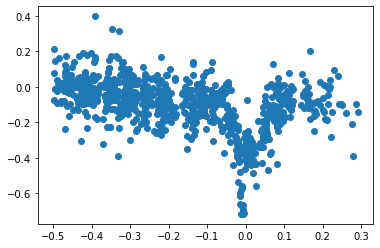

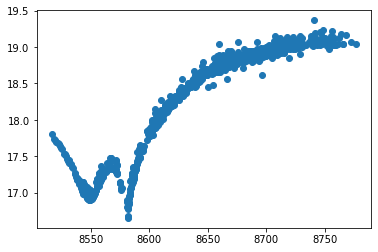

0.49130674336775143


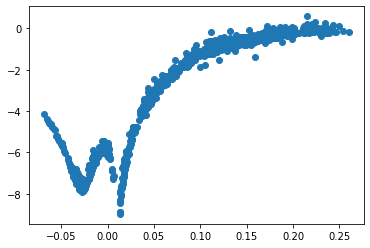

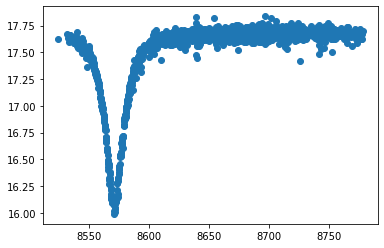

0.3654024621255684


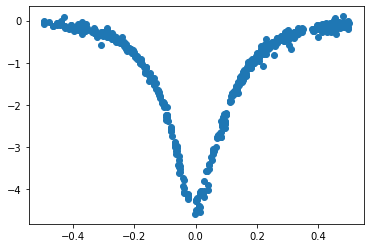

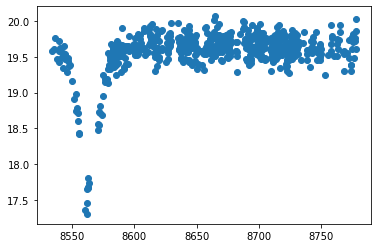

0.4887245048564788


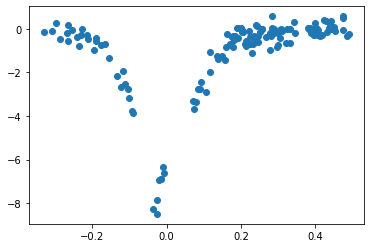

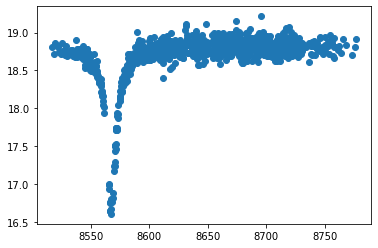

0.301320515519983


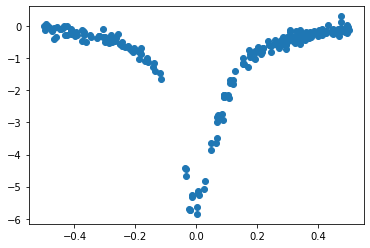

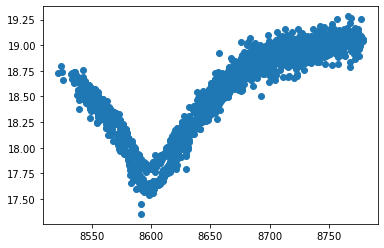

0.517354050591107


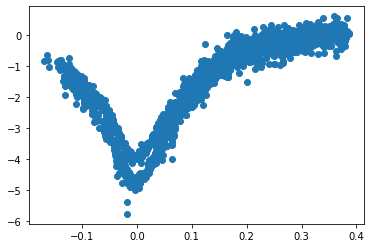

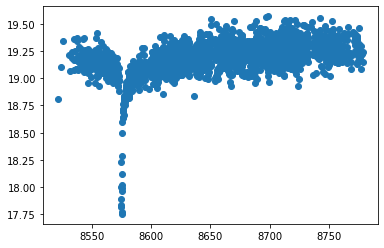

0.5373226272749292


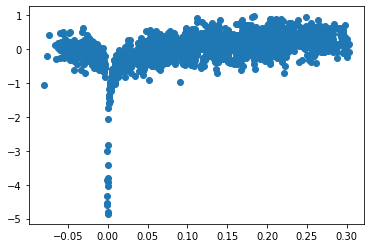

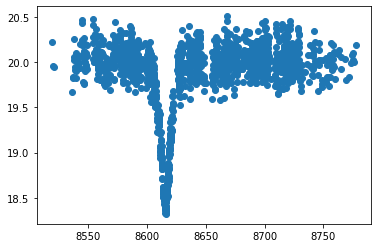

0.1873007670879319


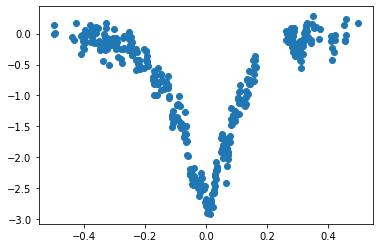

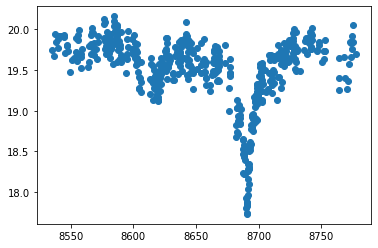

0.5499476342830294


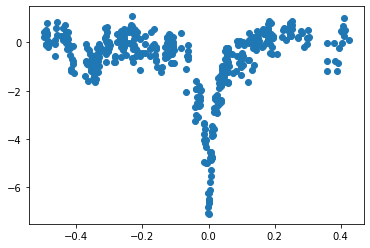

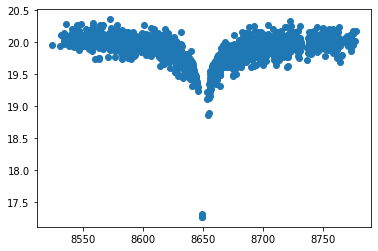

0.5151509875330131


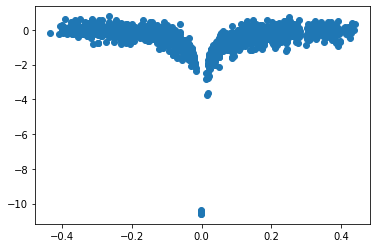

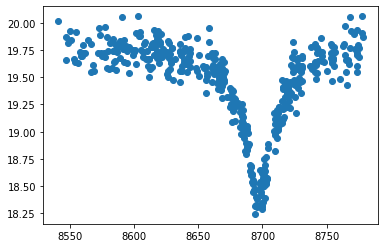

0.617901577394934


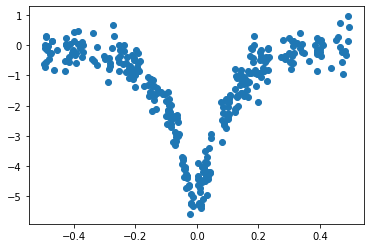

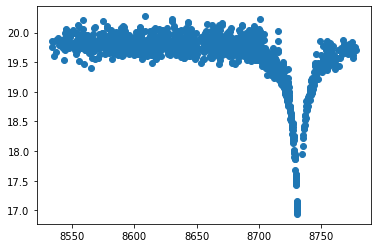

0.7020559513089105


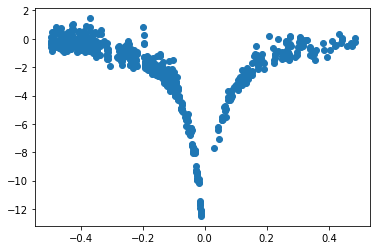

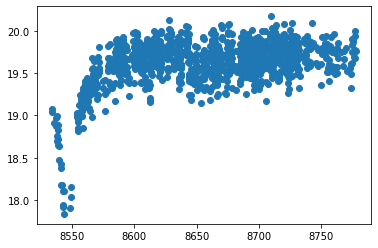

0.45687845495944646


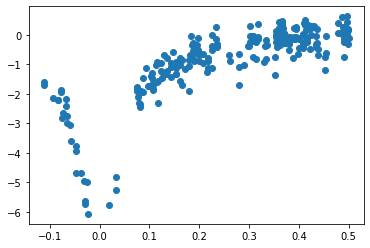

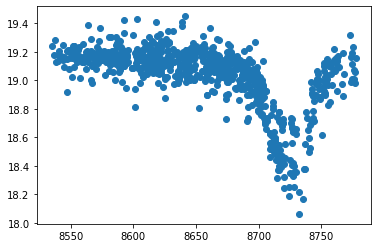

0.7304995761681274


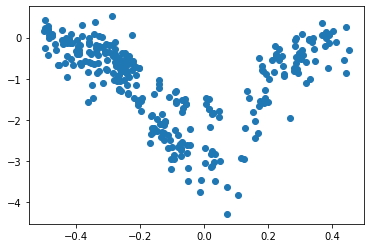

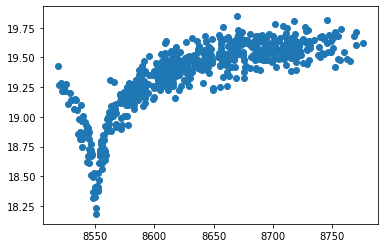

0.5253657853723026


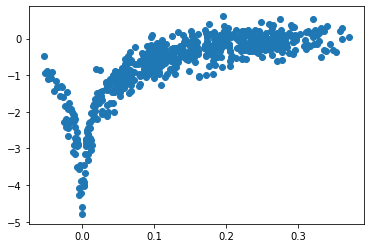

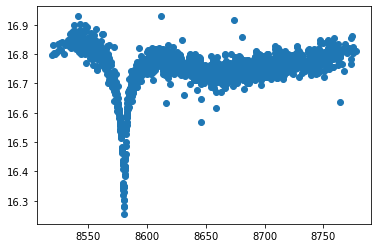

0.38525328263207265


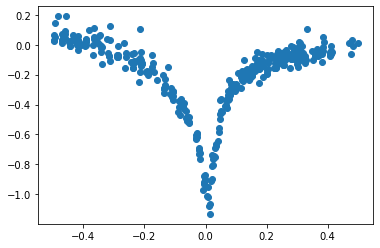

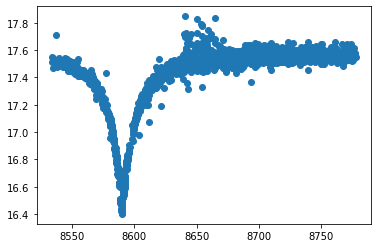

0.5020179400641354


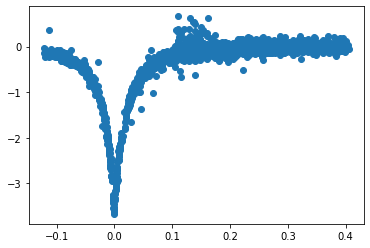

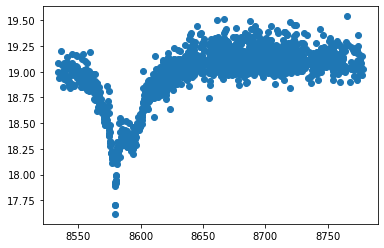

0.4889722751756764


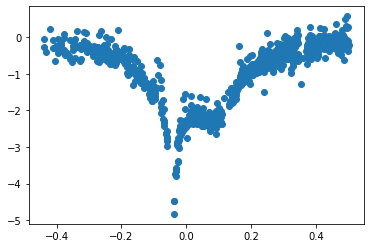

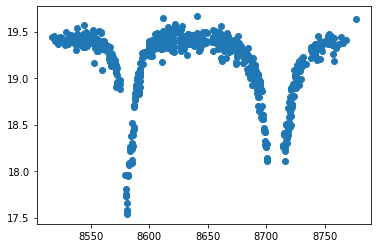

0.6459414236182717


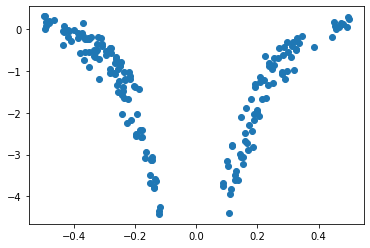

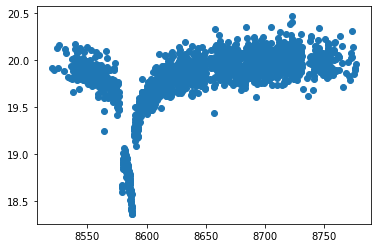

0.4690070640605499


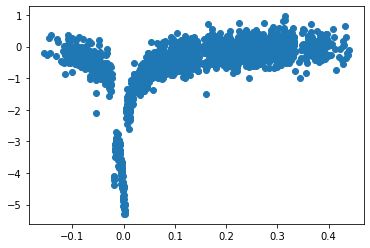

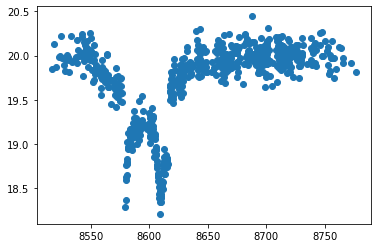

0.5203553339323139


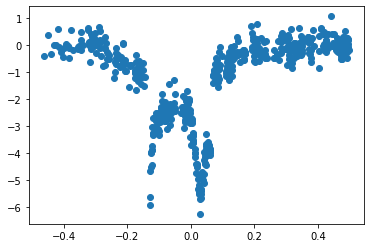

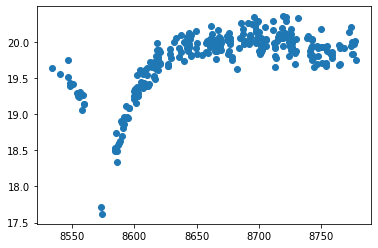

0.5538569672576112


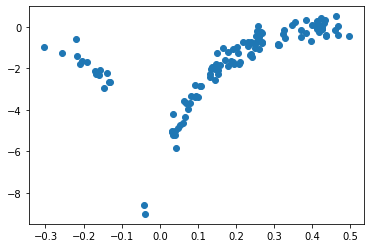

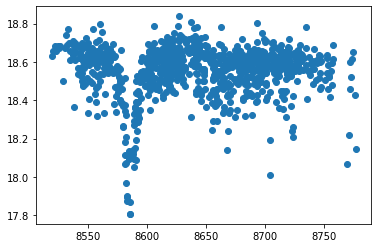

0.4014196743403332


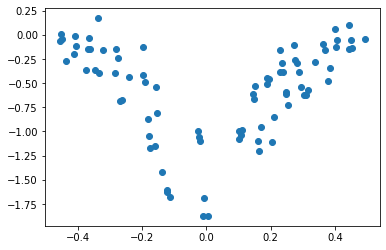

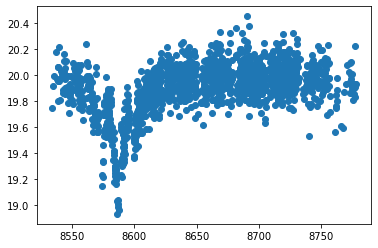

0.5121929018914156


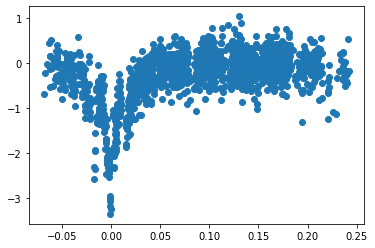

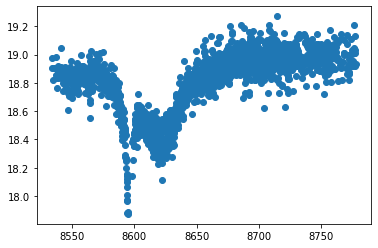

0.5390061964189728


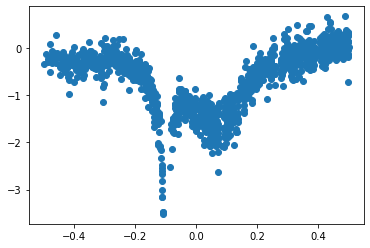

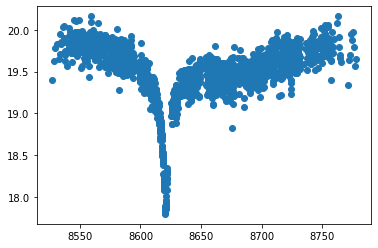

0.5184523706943104


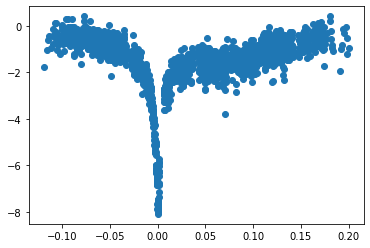

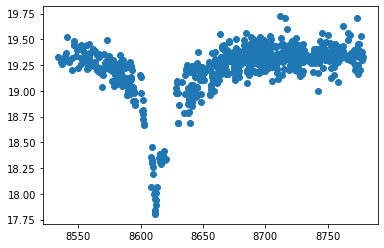

0.6158058859328301


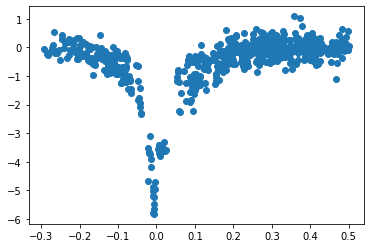

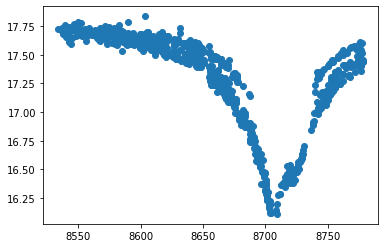

0.5652592090081437


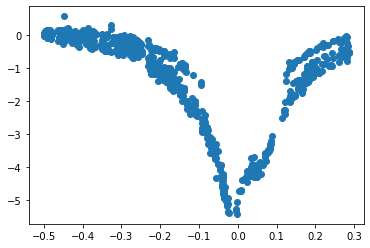

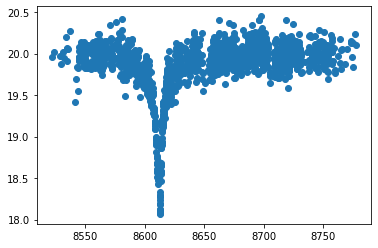

0.42202174518606206


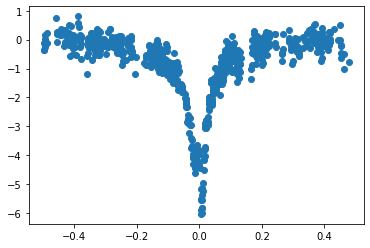

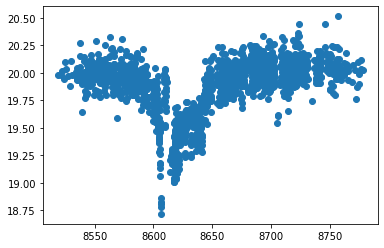

0.5351365364245911


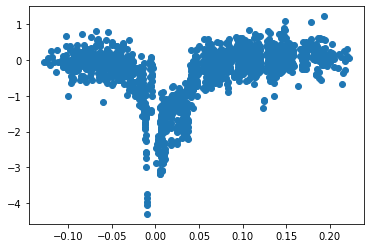

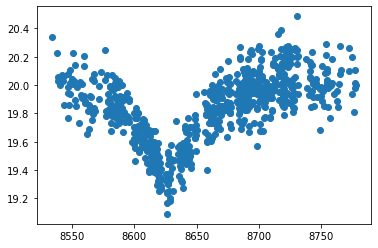

0.5509572025078942


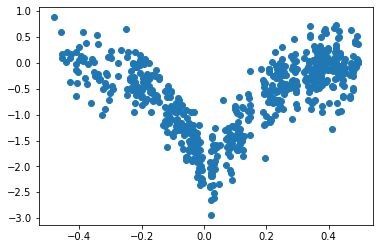

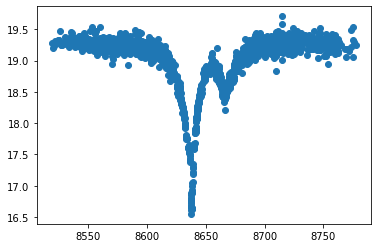

0.5236985147623423


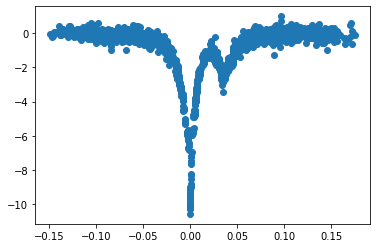

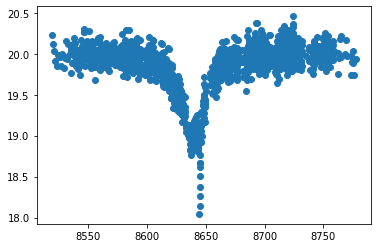

0.4865258876669952


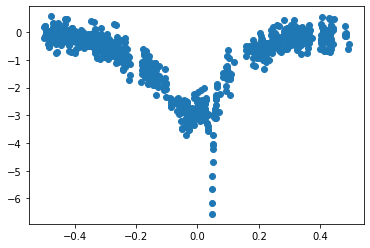

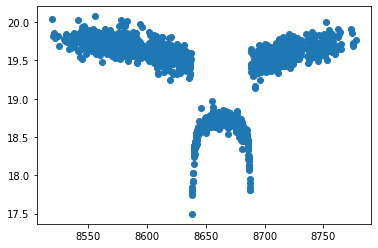

0.5326007894981568


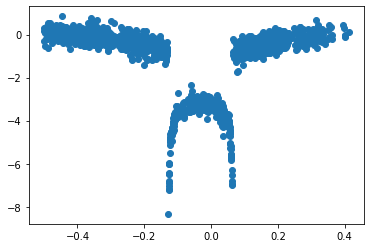

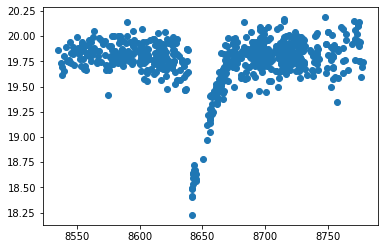

0.3519460263107782


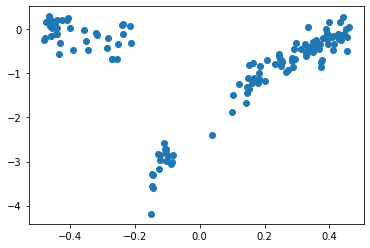

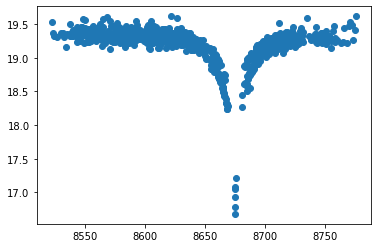

0.5046219341102848


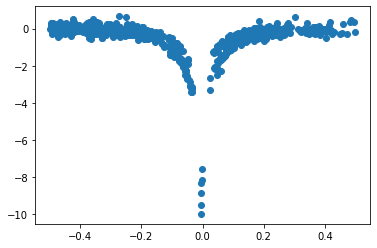

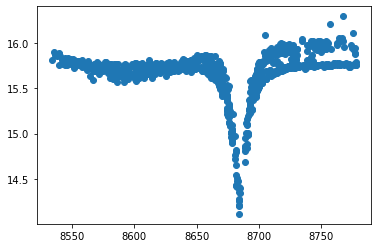

0.5754349492270464


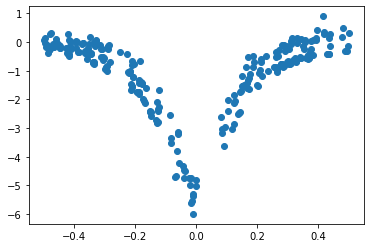

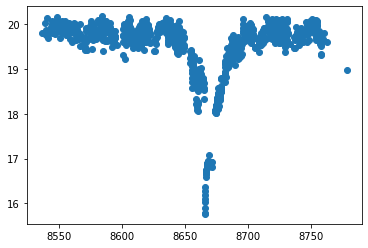

0.5374535032141375


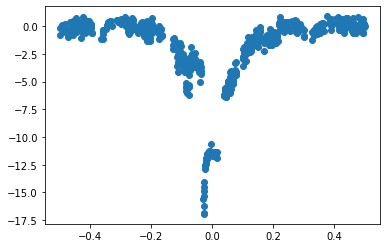

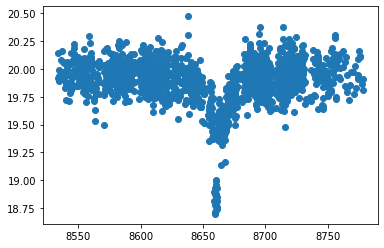

0.572762269316233


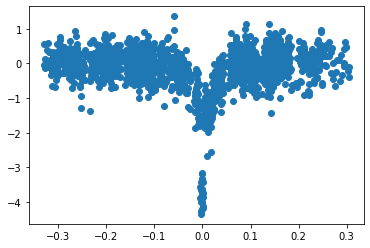

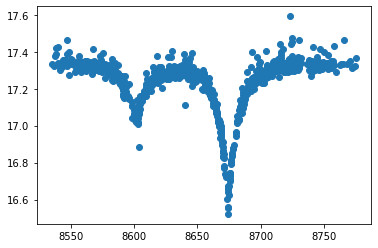

0.57200084214428


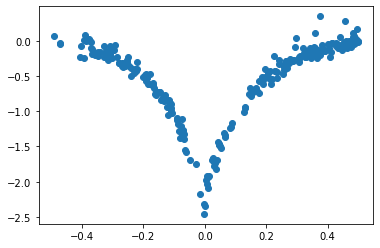

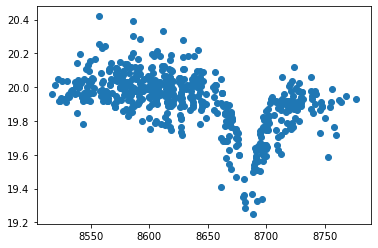

0.7267907078373622


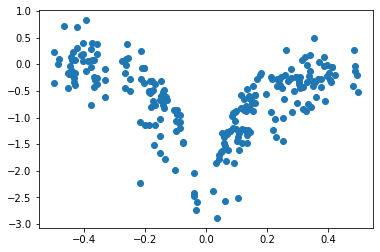

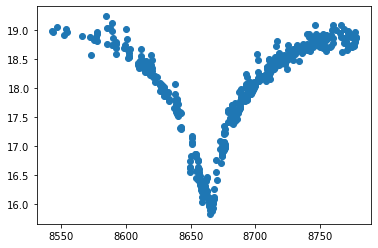

0.4943892941904443


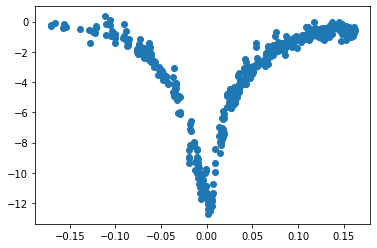

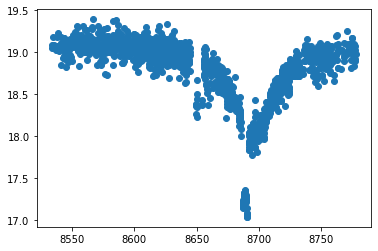

0.5386388100081214


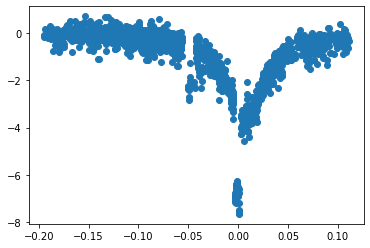

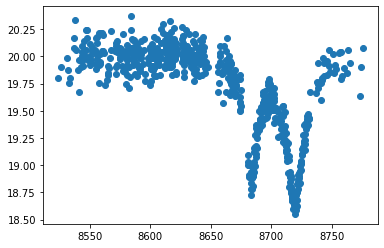

0.5429347241269757


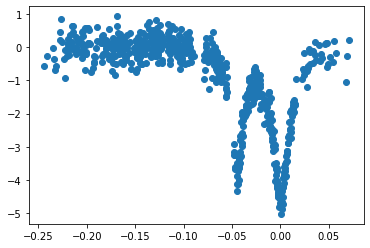

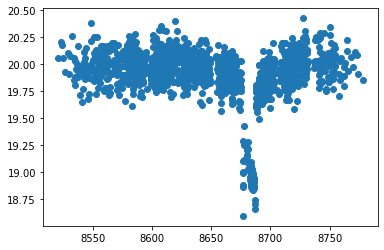

0.5577981473341349


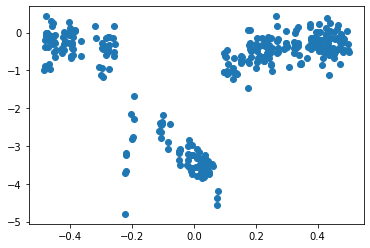

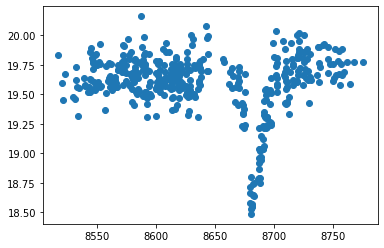

0.4977265615192266


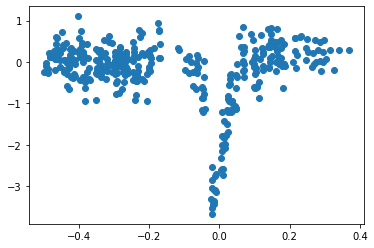

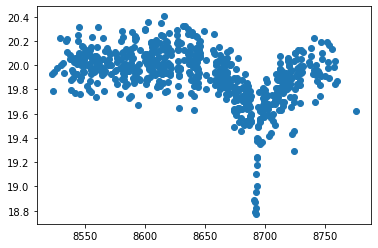

0.5415200412104479


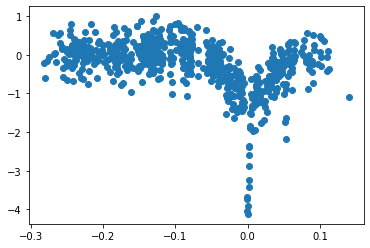

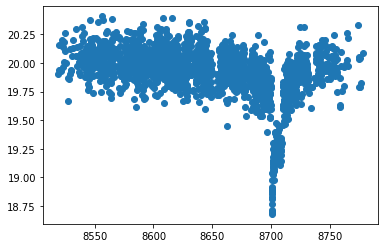

0.6793541052954392


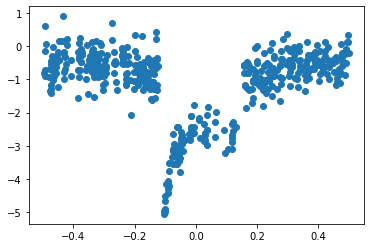

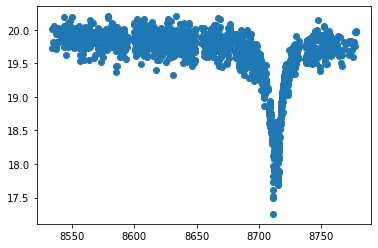

0.6006107801894194


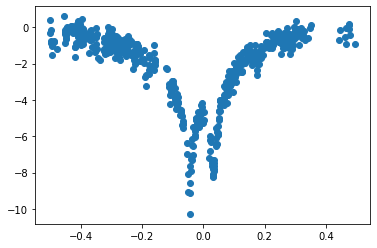

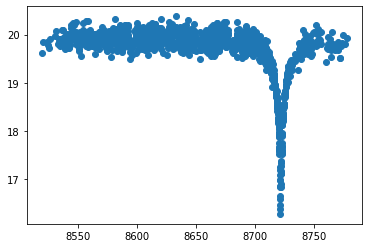

0.6524272637943576


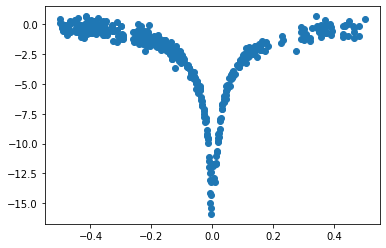

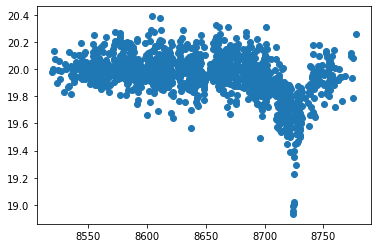

0.5691230205299589


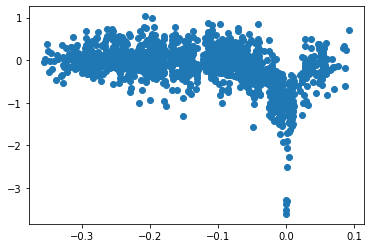

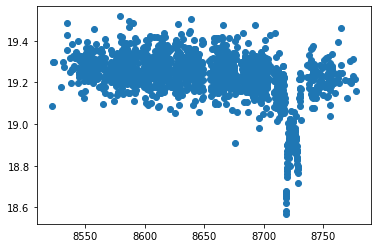

0.801395055869099


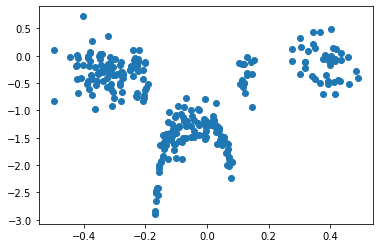

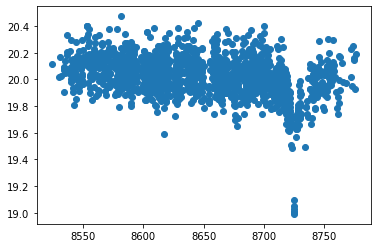

0.6289562434941194


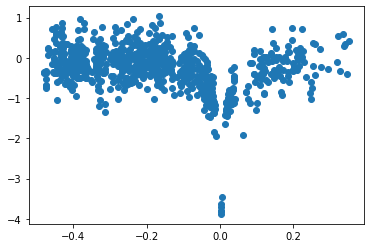

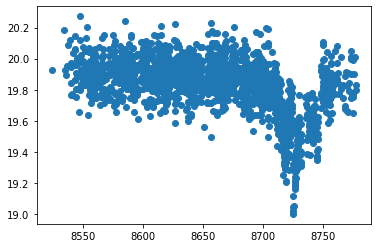

0.7135850675818679


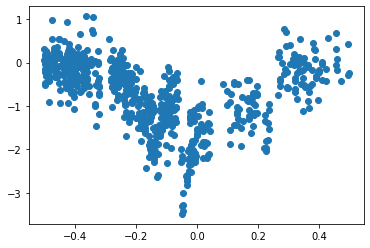

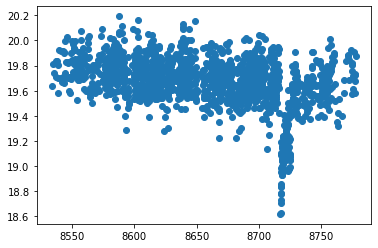

0.7651021492147253


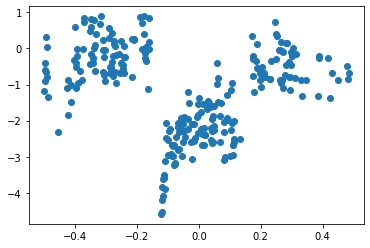

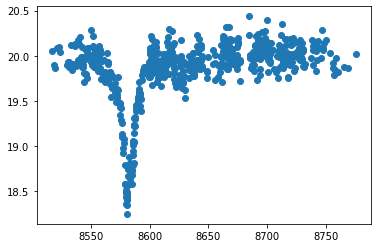

0.25992726932023497


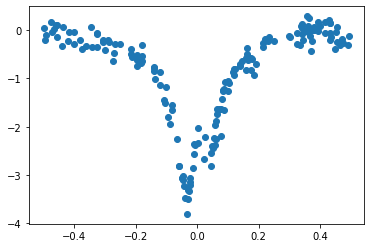

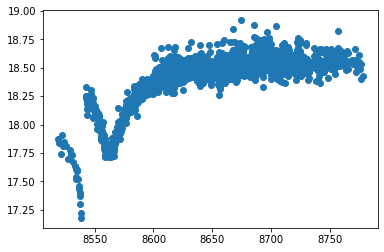

0.5439527318678483


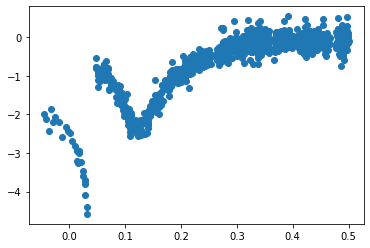

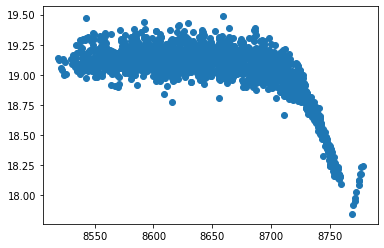

0.6179809588107722


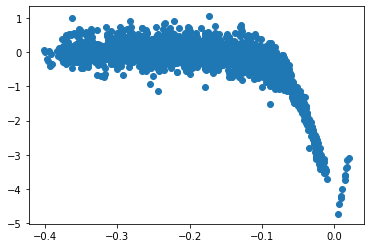

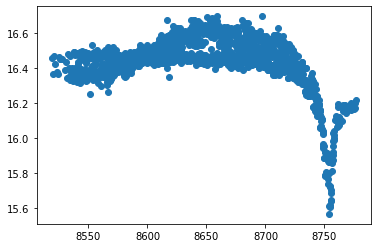

0.7393935665290383


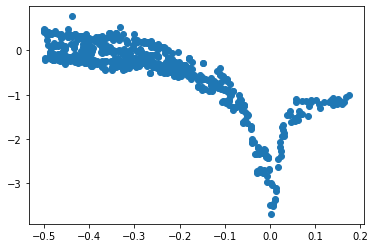

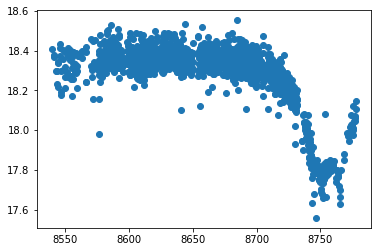

0.6781083332577699


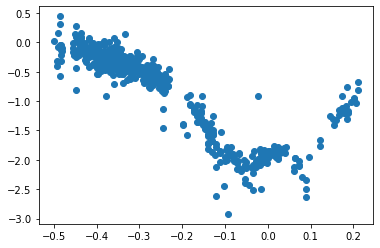

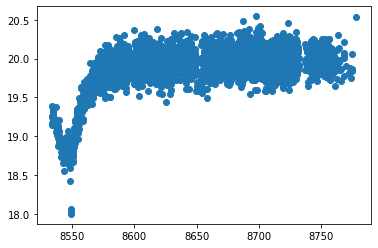

0.43150902904587446


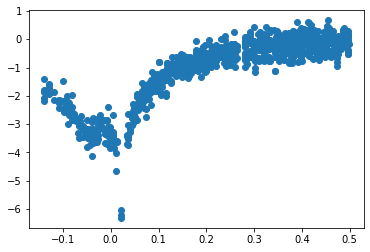

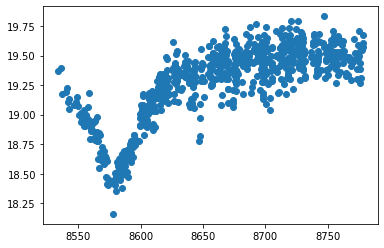

0.5384137543236696


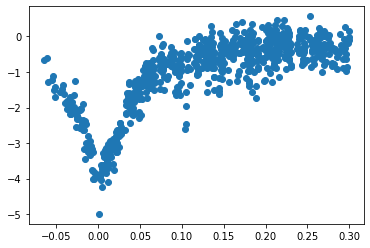

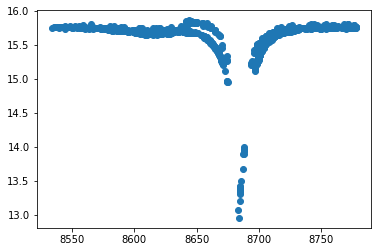

0.7177008921580363


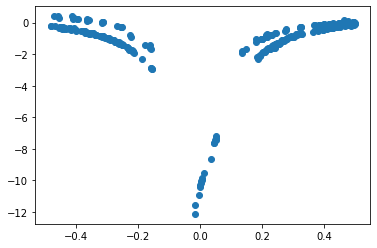

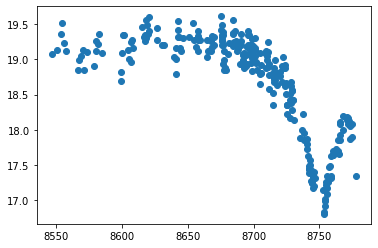

0.6756903578455584


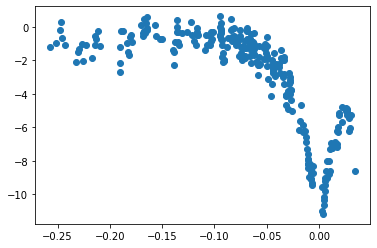

  0%|          | 0/68 [00:00<?, ?it/s]

In [26]:
max_len = 0
lc = []
fs_list = []
for i in tqdm(range(len(eventid_list))):
    data = []
    for root, dirs, files in os.walk(targetdir + 'KMT-2019-BLG-' + eventid_list[i]):
        for f in files:
            if 'V' not in f:
                p = re.compile('___')
                file = open(f'{targetdir}KMT-2019-BLG-{eventid_list[i]}/{f}', 'r+')
                lines = [line for line in file.readlines() if p.search(line) is None]
                file.seek(0)
                file.truncate(0)
                file.writelines(lines)
                file.close()

                data.append(np.loadtxt(f'{targetdir}KMT-2019-BLG-{eventid_list[i]}/{f}'))
    data = np.vstack(data)
    data = data[np.argsort(data[:, 0])]

    # preprocess
    t0 = params[i, 0]; te = params[i, 1]; Ibase = params[i, -1]
    # print(t0, te, Ibase)

    # filter
    data = np.delete(data, np.where(data[:, 5] > 6.5), axis=0)
    data = np.delete(data, np.where(data[:, 5] < 0), axis=0)
    data = np.delete(data, np.where(data[:, 4] > data[:, 3] / 100), axis=0)
    # data = np.delete(data, np.where(data[:, 6]<1000), axis=0)
    for j in range(10):
        data = np.delete(data, np.where((np.abs(np.diff(data[:, 3])) > 0.3)), axis=0)
    plt.scatter(data[:, 0], data[:, 3])
    plt.show()

    # Ibase
    if len(data[np.abs(data[:, 0] - t0) > 0.3 * 4 * te][:, 3]) == 0:
        m0 = Ibase
    else:
        m0 = data[np.abs(data[:, 0] - t0) > 0.3 * 4 * te][:, 3].mean()
    flux = 10. ** ((m0 - data[:, 3]) / 2.5)
    data[:, 3] = 22 - 2.5 * np.log10(1000 * flux)

    # fs
    t_scaled = (data[:, 0] - t0) / te * 5 + 36
    x = torch.tensor(np.stack([t_scaled, data[:, 3]], axis=-1)).unsqueeze(0)
    depth = 2; window_length = 1; 
    train_logsig = torchcde.logsig_windows(x, depth, window_length=window_length)
    train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig)
    fs = 10**(model_s(train_coeffs.float().to(device)).detach().cpu().item())
    print(fs)
    fs_list.append(fs)

    data[:, 3] = - 2.5 * np.log10(flux * fs + 1 - fs) / 0.2

    # data[:, 3] = (data[:, 3] - 14.5) / 0.2

    # time rescale
    data = data[(data[:, 0] > t0 - 2 * te) * (data[:, 0] < t0 + 2 * te)]
    data[:, 0] = (data[:, 0] - t0) / (4 * te)
    plt.scatter(data[:, 0], data[:, 3])
    plt.show()
    data = torch.tensor(data[:, [0, 3]]).unsqueeze(0)
    depth = 3; window_length = max(data.shape[-2]//100, 1)
    data = torchcde.logsig_windows(data, depth, window_length=window_length).squeeze(0)
    max_len = max(max_len, data.shape[-2])
    lc.append(data)

data = torch.zeros(len(eventid_list), max_len, data.shape[-1])
for i in tqdm(range(len(eventid_list))):
    data[i] = torch.cat([lc[i], lc[i][-1].expand(max_len - len(lc[i]), lc[i].shape[-1])])

with h5py.File(targetdir + 'processed_data.h5', mode='w') as dataset_file:
    dataset_file['X'] = data

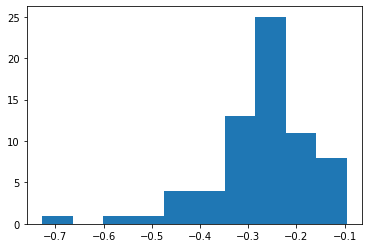

In [28]:
plt.hist(np.log10(fs_list))
plt.show()